In [1]:
# importing important libraries
import pandas as pd
import numpy as np
import os
import shutil
import multiprocessing
import glob
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re
import csv

In [2]:
# Seting the path to the folder containing files
folder_path = 'C:\\Users\\Shashank Rawat\\Desktop\\Data Science assignment\\New folder\\EyeT\\EyeT'

In [3]:
for file in os.listdir(folder_path):
    print(file)

columns_explained.pdf
coordinate_system.pdf
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_0.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_1.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_10.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_11.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_12.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_13.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_14.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_15.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_16.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_17.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_18.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_19.csv
EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_2.c

### Defining some functions to perform data cleaning to merging all the csv into one final dataset

In [4]:
# Function to drop Cloumns
def Drop_coloumn1(df):
    Columns_to_drop=['Unnamed: 0','Recording timestamp','Recording duration','Recording date','Eyetracker timestamp','Project name','Computer timestamp','Export date','Recording start time UTC',
                'Recording date UTC','Recording resolution width','Timeline name','Recording Fixation filter name',
                'Recording software version','Recording start time','Gaze event duration','Eye movement type',
                'Recording resolution height','Recording monitor latency','Event','Event value','Presented Stimulus name',
                'Presented Media name','Mouse position X','Mouse position Y','Presented Media width','Presented Media height',
                'Presented Media position X (DACSpx)','Eye movement type index','Presented Media position Y (DACSpx)','Original Media width','Original Media height',
                ]
    for col in Columns_to_drop:
        if col in df.columns:
            df.drop(col,inplace=True,axis=1)
        
#     df.drop(columns=Columns_to_drop,inplace=True)
    # retaing observation with observation having sensor as Eye Tracker
    df = df[df['Sensor']=='Eye Tracker'].reset_index(drop=True)
    # dropping Sensor coloumn
    df.drop(columns='Sensor',inplace=True)
    # droping coloumn with invalid validity right
    df.drop(df[df['Validity right'] == 'Invalid'].index, inplace=True)
    # dropping coloumn with validity left
    df.drop(df[df['Validity left'] == 'Invalid'].index, inplace=True)
    # dropping both Validy left and validity right
    df.drop(columns=['Validity left','Validity right'],inplace=True)

    return df


In [5]:
# a udf to covert variable from object to float.
def converter(df):
    def convert_to_float(df, col_list):
        for col in col_list:
            df[col]=df[col].astype(str).astype(float)
        return df
    #Replacing ',' into '.'
    df.replace(regex=[','],value='.',inplace=True)
    couloumn_to_convert=['Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y',
                    'Gaze direction right Z','Pupil diameter left','Pupil diameter right','Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)', 
                    'Eye position left Z (DACSmm)', 'Eye position right X (DACSmm)','Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
                    'Gaze point left X (DACSmm)', 'Gaze point left Y (DACSmm)','Gaze point right X (DACSmm)', 'Gaze point right Y (DACSmm)',
                    'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)','Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)',
                    'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)','Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)']
    df= convert_to_float(df,couloumn_to_convert)
    return df


In [6]:
# udf for null values treatment:
def null_handle(df):
    df.drop(columns=['Fixation point X','Fixation point Y',
                        'Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)'],inplace=True)
    column=['Gaze point X (MCSnorm)','Gaze point right Y (MCSnorm)','Gaze point right X (MCSnorm)','Pupil diameter left','Pupil diameter right',
         'Gaze point left Y (MCSnorm)','Gaze point left X (MCSnorm)','Gaze point Y (MCSnorm)']
    for col in column:
        df[col] = df[col].transform(lambda x: x.fillna(x.mean()))
        
    return df

    

In [7]:
# udf to drop coloumns after final selection:
def Drop_coloumn2(df):
    col_to_drop=[ 'Gaze point left X','Gaze point left Y', 'Gaze point right X', 'Gaze point right Y', 'Gaze direction left X', 'Gaze direction left Y',
                'Gaze direction left Z', 'Gaze direction right X','Gaze direction right Y','Gaze direction right Z',
                'Gaze point right X (DACSmm)', 'Gaze point right Y (DACSmm)',
                'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)',
                'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)','Eye position left Z (DACSmm)','Eye position right Z (DACSmm)',
                'Gaze point left X (DACSmm)','Gaze point left Y (DACSmm)']
    df.drop(columns=col_to_drop,inplace=True)
    return df

In [8]:
# udf to merge all the data of the file to a single observation:
def file_merge(df):
    numeric_col=['Gaze point X','Gaze point Y','Pupil diameter left','Pupil diameter right','Eye position left X (DACSmm)',
                'Eye position left Y (DACSmm)','Eye position right X (DACSmm)','Eye position right Y (DACSmm)','Gaze point X (MCSnorm)',
                'Gaze point Y (MCSnorm)']
    new_df= pd.DataFrame(df[numeric_col].mean()).transpose()
    new_df['Participant name']=df['Participant name'].iloc[1]
    
    return new_df

In [9]:
# Defining the participant numbers 
participant_numbers = list(range(61))

# regular expression pattern to match the file names
pattern_1 = r'^EyeT_group_dataset_III_image_name_letter_card_participant_({0})_trial_(\d+)\.csv$'.format('|'.join(str(n) for n in participant_numbers))
pattern_2 = r'EyeT_group_dataset_II_image_name_grey_orange_participant_({0})_trial_(\d+)\.csv'.format('|'.join(str(n) for n in participant_numbers))
pattern_3 = r'^EyeT_group_dataset_II_image_name_grey_blue_participant_({0})_trial_(\d+)\.csv$'.format('|'.join(str(n) for n in participant_numbers))



regex_1 = re.compile(pattern_1)
regex_2=re.compile(pattern_2)
regex_3= re.compile(pattern_3)
list1=[]
list2=[]
# Looping over files in folder
for filename in os.listdir(folder_path):
   
    match_1 = regex_1.match(filename)
    match_2 = regex_2.match(filename)
    match_3 = regex_3.match(filename)
    if (match_1):
       
        participant_number = int(match_1.group(1))
       #print(participant_number)
        
        file_path = os.path.join(folder_path, filename)
       #creating a dataframe df to store the csv file
        df=pd.read_csv(file_path,index_col=None,header=0)
        # correcting the wrong participant number  in the csv file for participant 11 
        if((participant_number == 11) and (df['Participant name'].iloc[1]=='Participant0001')):
            #replacement function
            replace_fn = lambda s, n: s.replace('0001', f'00{n:02d}')
            df['Participant name']=df['Participant name'].apply(replace_fn, args=(participant_number,))
            
        df=Drop_coloumn1(df)
        df=converter(df)
        df=null_handle(df)
        df=Drop_coloumn2(df)
        df=file_merge(df)
        list1.append(df)
       
    elif (match_2):
        
        file_path = os.path.join(folder_path, filename)
        df=pd.read_csv(file_path,index_col=None,header=0)
        
        if((participant_number == 11) and (df['Participant name'].iloc[1]=='Participant0001')):
            #replacement function
            replace_fn = lambda s, n: s.replace('0001', f'00{n:02d}')
            df['Participant name']=df['Participant name'].apply(replace_fn, args=(participant_number,))
            
        df=Drop_coloumn1(df)
        df=converter(df)
        df=null_handle(df)
        df=Drop_coloumn2(df)
        df=file_merge(df)
        list1.append(df)
        
    elif (match_3):
        participant_number = int(match_3.group(1))
        print(participant_number)
        
        file_path = os.path.join(folder_path, filename)
        df=pd.read_csv(file_path,index_col=None,header=0)
        
        if((participant_number == 11) and (df['Participant name'].iloc[1]=='Participant0001')):
            #replacement function
            replace_fn = lambda s, n: s.replace('0001', f'00{n:02d}')
            df['Participant name']=df['Participant name'].apply(replace_fn, args=(participant_number,))
            
        df=Drop_coloumn1(df)
        df=converter(df)
        df=null_handle(df)
        df=Drop_coloumn2(df)
        df=file_merge(df)
        list1.append(df)
    
        
combine_data=pd.concat(list1,axis=0,join='outer')

C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\197201242

C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1972012424.py:29: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path,index_col=None,header=0)
C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\197201242

10
10
10
10
14
14
18
18
18
18
24
24
26
26
28
28
2
2
2
2
30
30
32
34
34
36
38
38
40
40
42
42
44
44
46
46
48
48
4
4
4
4
4
4
4
4
50
50
52
52
54
54
56
56
58
58
60
60
6
6
6
6
6
6
6
6
6
6
6
6
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


In [10]:
combine_data

,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Participant name
0,1077.925530,250.162653,3.076304,3.050783,191.980721,75.460788,259.328193,75.505836,0.559241,0.342348,Participant0011
0,968.237988,303.839246,2.997197,3.008782,188.535653,55.816375,255.862775,50.951250,0.508940,0.388764,Participant0011
0,1014.149564,529.892501,3.009163,3.075269,211.669960,120.653134,278.230465,121.021457,0.534915,0.481626,Participant0003
0,985.887644,558.160457,2.906045,2.980678,207.472200,125.334072,274.080641,123.827953,0.517053,0.516533,Participant0003
0,1004.454811,491.273656,2.833913,2.885869,208.148786,125.473112,274.742163,123.687007,0.528103,0.456081,Participant0003
...,...,...,...,...,...,...,...,...,...,...,...
0,946.895572,618.962684,2.995000,2.880398,229.192732,93.933974,292.814369,99.054470,0.496867,0.567743,Participant0056
0,943.405257,430.544163,4.356261,4.328563,233.702903,100.698518,292.054187,99.615724,0.484067,0.416919,Participant0058
0,937.782165,423.942613,4.124682,4.094539,233.634465,101.102342,292.053271,100.506374,0.482479,0.392778,Participant0058
0,879.065739,436.033037,3.272498,3.151034,228.820124,129.584035,294.613198,127.686265,0.439417,0.405986,Participant0060


In [11]:
# setting all coloumns in proper order
cols = combine_data.columns.tolist()
cols = [cols[-1]] + cols[:-1]
combine_data = combine_data[cols]



In [12]:
combine_data.head()

,Participant name,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Gaze point X (MCSnorm),Gaze point Y (MCSnorm)
0,Participant0011,1077.925530,250.162653,3.076304,3.050783,191.980721,75.460788,259.328193,75.505836,0.559241,0.342348
0,Participant0011,968.237988,303.839246,2.997197,3.008782,188.535653,55.816375,255.862775,50.951250,0.508940,0.388764
0,Participant0003,1014.149564,529.892501,3.009163,3.075269,211.669960,120.653134,278.230465,121.021457,0.534915,0.481626
0,Participant0003,985.887644,558.160457,2.906045,2.980678,207.472200,125.334072,274.080641,123.827953,0.517053,0.516533
0,Participant0003,1004.454811,491.273656,2.833913,2.885869,208.148786,125.473112,274.742163,123.687007,0.528103,0.456081


In [13]:
combine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 0 to 0
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Participant name               502 non-null    object 
 1   Gaze point X                   502 non-null    float64
 2   Gaze point Y                   502 non-null    float64
 3   Pupil diameter left            502 non-null    float64
 4   Pupil diameter right           502 non-null    float64
 5   Eye position left X (DACSmm)   502 non-null    float64
 6   Eye position left Y (DACSmm)   502 non-null    float64
 7   Eye position right X (DACSmm)  502 non-null    float64
 8   Eye position right Y (DACSmm)  502 non-null    float64
 9   Gaze point X (MCSnorm)         502 non-null    float64
 10  Gaze point Y (MCSnorm)         502 non-null    float64
dtypes: float64(10), object(1)
memory usage: 47.1+ KB


In [14]:
combine_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gaze point X,502.0,919.281024,79.745387,719.734088,860.609145,916.120534,964.520873,1226.475696
Gaze point Y,502.0,455.902546,113.041003,119.563128,364.259886,470.308584,545.875884,759.769898
Pupil diameter left,502.0,3.198620,0.500315,1.828596,2.919891,3.076304,3.369266,5.743452
Pupil diameter right,502.0,3.209185,0.482457,1.983675,2.931005,3.084408,3.425223,5.697669
Eye position left X (DACSmm),502.0,219.021439,20.645423,172.423252,202.890656,221.896810,233.879014,269.426402
Eye position left Y (DACSmm),502.0,75.975944,52.013634,-103.758089,43.778536,81.712616,120.145960,147.858681
Eye position right X (DACSmm),502.0,284.211584,19.470769,239.782535,269.779571,287.971680,296.484992,333.214649
Eye position right Y (DACSmm),502.0,76.371310,52.739167,-104.896181,44.826708,84.986121,119.941015,152.973243
Gaze point X (MCSnorm),502.0,0.467861,0.051038,0.265075,0.430041,0.464978,0.500703,0.674772
Gaze point Y (MCSnorm),502.0,0.452039,0.083055,0.176893,0.392918,0.446235,0.517235,0.696388


In [15]:
combine_data['Participant name'].nunique()

60

### compilation Successfull of the data for all 60 participant in single dataset 

### Loading Questionaire Dataset 

In [16]:
questionaire_df=pd.read_csv('C:\\Users\\Shashank Rawat\\Desktop\\Data Science assignment\\Questionnaire_datasetIB.csv',encoding= 'unicode_escape')

In [17]:
questionaire_df.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9534500,24.09.2020 16:00,24.09.2020 16:00,Yes,Proceed,1,3,4,4,4,4,4,3,3,4,3,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,2,4,137,109,5 minutes 5 seconds
1,2,9597659,30.09.2020 15:14,30.09.2020 15:14,Yes,Proceed,2,2,4,4,4,4,3,3,4,4,2,3,3,3,3,3,3,3,3,3,4,3,4,3,3,3,3,4,3,4,3,3,4,2,4,3,3,4,2,2,127,100,5 minutes 55 seconds
2,3,9637453,01.10.2020 16:20,01.10.2020 16:20,Yes,Proceed,4,1,4,4,4,4,4,3,3,3,3,4,4,3,3,3,3,4,3,3,3,3,3,3,2,2,2,4,3,3,3,4,2,3,3,3,2,3,3,2,123,98,6 minutes 49 seconds
3,4,9732460,06.10.2020 16:45,06.10.2020 16:45,Yes,Proceed,2,3

In [18]:
# udf to join the name of participant to correct format.
def get_participant_n(num):
    return 'Participant{:04d}'.format(num)

# creating new coloumn "participant name"
questionaire_df['Participant name'] = questionaire_df['Participant nr'].apply(get_participant_n)
# dropping participant nr coloumn.
questionaire_df.drop(columns='Participant nr',inplace=True)
# print the updated DataFrame
questionaire_df.head()

,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time,Participant name
0,9534500,24.09.2020 16:00,24.09.2020 16:00,Yes,Proceed,1,3,4,4,4,4,4,3,3,4,3,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,2,4,137,109,5 minutes 5 seconds,Participant0001
1,9597659,30.09.2020 15:14,30.09.2020 15:14,Yes,Proceed,2,2,4,4,4,4,3,3,4,4,2,3,3,3,3,3,3,3,3,3,4,3,4,3,3,3,3,4,3,4,3,3,4,2,4,3,3,4,2,2,127,100,5 minutes 55 seconds,Participant0002
2,9637453,01.10.2020 16:20,01.10.2020 16:20,Yes,Proceed,4,1,4,4,4,4,4,3,3,3,3,4,4,3,3,3,3,4,3,3,3,3,3,3,2,2,2,4,3,3,3,4,2,3,3,3,2,3,3,2,123,98,6 minutes 49 seconds,Participant0003
3,9732460,06.10.2

In [19]:
questionaire=questionaire_df[['Participant name','Total Score extended']]

In [20]:
questionaire.head()

,Participant name,Total Score extended
0,Participant0001,137
1,Participant0002,127
2,Participant0003,123
3,Participant0004,120
4,Participant0005,124


In [21]:
# making copy of the final dataset
df_1=combine_data.copy()

In [22]:
# Merge the two datasets on a common column
merged_df = pd.merge(df_1, questionaire, on='Participant name')

merged_df

,Participant name,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Total Score extended
0,Participant0011,1077.925530,250.162653,3.076304,3.050783,191.980721,75.460788,259.328193,75.505836,0.559241,0.342348,151
1,Participant0011,968.237988,303.839246,2.997197,3.008782,188.535653,55.816375,255.862775,50.951250,0.508940,0.388764,151
2,Participant0011,942.186709,320.608800,3.080095,3.098993,172.423252,119.836739,239.782535,115.661965,0.494273,0.440175,151
3,Participant0011,955.221556,383.277752,3.036228,3.060220,184.821067,70.116038,252.295506,68.085623,0.495362,0.442843,151
4,Participant0011,979.460632,326.717595,3.021398,3.059323,191.836998,66.424371,259.288832,66.752330,0.515166,0.451782,151
...,...,...,...,...,...,...,...,...,...,...,...,...
497,Participant0020,874.938903,349.691001,3.170033,3.158997,213.293617,57.890064,279.752586,64.951825,0.417143,0.344653,142
498,Participant0022,840.495863,510.078597,3.345397,3.271780,221.366655,86.665504,283.680773,90.442356,0.402840,0.486761,125
499,Participant0022,782.288631,473.736184,3.555417,3.458756,218.622967,85.971489,280.865927,89.343928,0.365390,0.457505,125
500,Participant0022,771.409063,416.801854,3.518880,3.449706,219.193759,87.251287,280.727065,90.396993,0.353197,0.408436,125


### Dividing Test And control Group:

In [23]:
merged_df['Participant name'].unique()

array(['Participant0011', 'Participant0003', 'Participant0005',
       'Participant0007', 'Participant0009', 'Participant0013',
       'Participant0015', 'Participant0017', 'Participant0019',
       'Participant0001', 'Participant0021', 'Participant0023',
       'Participant0025', 'Participant0027', 'Participant0029',
       'Participant0031', 'Participant0033', 'Participant0035',
       'Participant0037', 'Participant0039', 'Participant0041',
       'Participant0043', 'Participant0045', 'Participant0047',
       'Participant0049', 'Participant0051', 'Participant0053',
       'Participant0055', 'Participant0057', 'Participant0059',
       'Participant0010', 'Participant0014', 'Participant0018',
       'Participant0024', 'Participant0026', 'Participant0028',
       'Participant0002', 'Participant0030', 'Participant0032',
       'Participant0034', 'Participant0036', 'Participant0038',
       'Participant0040', 'Participant0042', 'Participant0044',
       'Participant0046', 'Participant00

In [24]:
test_group_participant=['Participant0011', 'Participant0003', 'Participant0005','Participant0007', 'Participant0009', 'Participant0013',
            'Participant0015', 'Participant0017', 'Participant0019','Participant0001', 'Participant0021', 'Participant0023',
            'Participant0025', 'Participant0027', 'Participant0029','Participant0031', 'Participant0033', 'Participant0035',
            'Participant0037', 'Participant0039', 'Participant0041','Participant0043', 'Participant0045', 'Participant0047',
            'Participant0049', 'Participant0051', 'Participant0053','Participant0055', 'Participant0057', 'Participant0059']
control_group_participant=['Participant0010', 'Participant0014', 'Participant0018', 'Participant0024', 'Participant0026', 'Participant0028',
                           'Participant0002', 'Participant0030', 'Participant0032','Participant0034', 'Participant0036', 'Participant0038',
                           'Participant0040', 'Participant0042', 'Participant0044','Participant0046', 'Participant0048', 'Participant0004',
                           'Participant0050', 'Participant0052', 'Participant0054','Participant0056', 'Participant0058', 'Participant0060',
                           'Participant0006', 'Participant0008', 'Participant0012',
                            'Participant0016', 'Participant0020', 'Participant0022']

In [25]:
test_group_df = merged_df[merged_df['Participant name'].isin(test_group_participant)]
control_group_df = merged_df[merged_df['Participant name'].isin(control_group_participant)]

### Basic Data Exploration:

In [26]:
print(test_group_df.shape)
print(control_group_df.shape)

(360, 12)
(142, 12)


In [27]:
test_group_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gaze point X,360.0,915.604905,74.063554,754.346959,857.876850,913.888796,958.265717,1205.170635
Gaze point Y,360.0,474.108218,111.268585,192.227409,388.995959,488.915310,562.083182,683.808869
Pupil diameter left,360.0,3.081294,0.381396,1.828596,2.901042,3.015670,3.222285,4.681485
Pupil diameter right,360.0,3.108179,0.377381,2.041319,2.901692,3.037683,3.308707,4.637204
Eye position left X (DACSmm),360.0,217.873437,21.074399,172.423252,194.358045,221.486201,234.132189,262.916687
Eye position left Y (DACSmm),360.0,81.215360,50.383111,-76.509321,50.393881,91.329907,120.760298,147.858681
Eye position right X (DACSmm),360.0,282.850353,19.522060,239.782535,260.687467,286.315817,296.487050,326.861658
Eye position right Y (DACSmm),360.0,81.317432,50.654924,-75.780614,50.582211,93.237758,120.737137,144.234198
Gaze point X (MCSnorm),360.0,0.464950,0.048041,0.366617,0.427133,0.460412,0.495590,0.577713
Gaze point Y (MCSnorm),360.0,0.474010,0.072007,0.310203,0.430431,0.468293,0.526680,0.633154


In [28]:
control_group_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gaze point X,142.0,928.600761,92.236272,719.734088,869.134208,920.365845,979.486054,1226.475696
Gaze point Y,142.0,409.747322,104.352714,119.563128,354.062383,395.741169,458.784957,759.769898
Pupil diameter left,142.0,3.496067,0.628338,2.068269,3.071602,3.345163,3.920041,5.743452
Pupil diameter right,142.0,3.465254,0.610220,1.983675,3.065402,3.347767,3.865913,5.697669
Eye position left X (DACSmm),142.0,221.931866,19.281957,175.407660,208.127007,223.392538,232.804878,269.426402
Eye position left Y (DACSmm),142.0,62.692919,53.869508,-103.758089,29.886946,75.048692,101.001386,146.304581
Eye position right X (DACSmm),142.0,287.662591,18.973206,240.711602,274.160754,289.806465,296.290719,333.214649
Eye position right Y (DACSmm),142.0,63.831844,55.937569,-104.896181,25.980715,74.187311,100.358670,152.973243
Gaze point X (MCSnorm),142.0,0.475242,0.057471,0.265075,0.435345,0.478346,0.503175,0.674772
Gaze point Y (MCSnorm),142.0,0.396338,0.083375,0.176893,0.342300,0.388821,0.439082,0.696388


In [29]:
#  missing values check
print(test_group_df.isnull().sum())
print(control_group_df.isnull().sum())

Participant name                 0
Gaze point X                     0
Gaze point Y                     0
Pupil diameter left              0
Pupil diameter right             0
Eye position left X (DACSmm)     0
Eye position left Y (DACSmm)     0
Eye position right X (DACSmm)    0
Eye position right Y (DACSmm)    0
Gaze point X (MCSnorm)           0
Gaze point Y (MCSnorm)           0
Total Score extended             0
dtype: int64
Participant name                 0
Gaze point X                     0
Gaze point Y                     0
Pupil diameter left              0
Pupil diameter right             0
Eye position left X (DACSmm)     0
Eye position left Y (DACSmm)     0
Eye position right X (DACSmm)    0
Eye position right Y (DACSmm)    0
Gaze point X (MCSnorm)           0
Gaze point Y (MCSnorm)           0
Total Score extended             0
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


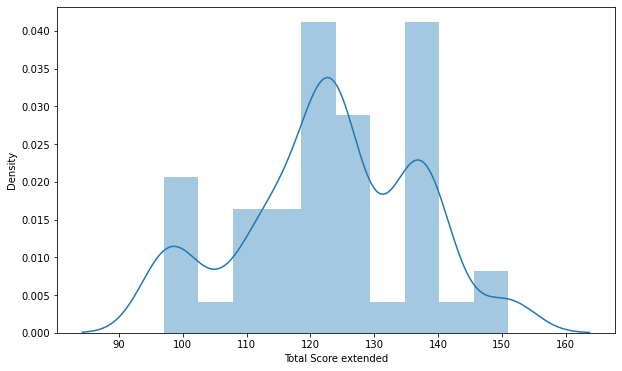

In [30]:
# Assumtion check
# Distribution of  target variables for test_group.
fig = plt.figure(figsize=(10, 6))
sns.distplot(test_group_df['Total Score extended'])
plt.show()

####  Empathy score for test group is not skewed and largergly follow normal distribution.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


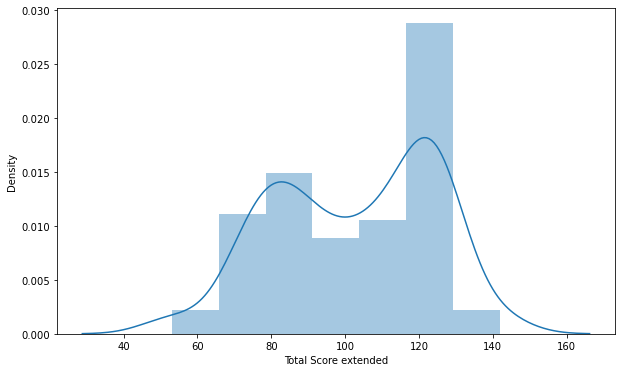

In [31]:
# Distribution of  target variables for control_group.
fig = plt.figure(figsize=(10, 6))
sns.distplot(control_group_df['Total Score extended'])
plt.show()

####  Empathy score for control group is also not skewed.

# Modelling:

## For Test Group:

As the dataset has very less obserbation we will use one participant data for the test and with the rest data we will use K fold Cross validation 

In [32]:
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [33]:
# Split the data based on the value of 'participant name'
test_group_df_test = test_group_df[test_group_df['Participant name'] == 'Participant0039']
test_group_df_train = test_group_df[test_group_df['Participant name'] !=  'Participant0039']


## 1.Linear Regresssion:

In [34]:

# Spliting the dataset into features and target
X = test_group_df_train.drop(columns=['Total Score extended','Participant name'])
y = test_group_df_train['Total Score extended']


# Create a scaler object to scale the data
scaler = StandardScaler()

# creating empty list to store the predictions and r-squre scores
predictions = []
r_squared_values = []

# Initialize the 10-fold cross-validation 
kf = KFold(n_splits=10, shuffle=True, random_state=123)

# Iterating over splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scaling the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # making a linear model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    # Predicting for test samples
    y_pred = lr.predict(X_test_scaled)

    # Appending the predictions to the list
    predictions.extend(y_pred)
    
    # Calculating the R-squared of the model 
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)



Mean Squared Error: 266.57983235160253
Mean R-squared: 0.24419430096553577


In [35]:
# To predict the target value for participant 39
new_observation = test_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
lr.fit(scaler.transform(X), y)
new_prediction = lr.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Mean Predicted Target Value: 117.39675380755037


In [36]:
# Creating a dataframe to store predictions and scores
Result_test=pd.DataFrame(data=[["Linear Regression ",test_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

In [37]:
Result_test

,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Linear Regression,126,117.396754,266.579832,0.244194


## 2.Decision Tree:


Repeating the whole process for Decison Tree Regressor

In [38]:
predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)
mse_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    tree = DecisionTreeRegressor()
    tree.fit(X_train_scaled, y_train)

    y_pred = tree.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)


Mean Squared Error: 366.87681818181807
Mean R-squared: 0.5646196396609564


In [39]:
# To predict the target value for participant 39
new_observation = test_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
tree.fit(scaler.transform(X), y)
new_prediction = tree.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Mean Predicted Target Value: 130.75


In [40]:
Result_decision_tree=pd.DataFrame(data=[["Decision Tree Regressor ",test_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_test=Result_decision_tree.append(Result_test,ignore_index=True)
Result_test

C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1794701162.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_test=Result_decision_tree.append(Result_test,ignore_index=True)


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Decision Tree Regressor,126,130.750000,366.876818,0.564620
1,Linear Regression,126,117.396754,266.579832,0.244194


## 3. Random Forest Regressor:

In [41]:
predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)
mse_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rdforest = RandomForestRegressor()
    rdforest.fit(X_train_scaled, y_train)

    y_pred = rdforest.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)


Mean Squared Error: 311.21540619968454
Mean R-squared: 0.7428239801043406


In [42]:
# To predict the target value for participant 39
new_observation = test_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
rdforest.fit(scaler.transform(X), y)
new_prediction = rdforest.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Mean Predicted Target Value: 124.62625


In [43]:
Result_rdforest=pd.DataFrame(data=[["Random Forest Regressor ",test_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_test=Result_rdforest.append(Result_test,ignore_index=True)
Result_test

C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\644236728.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_test=Result_rdforest.append(Result_test,ignore_index=True)


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Random Forest Regressor,126,124.626250,311.215406,0.742824
1,Decision Tree Regressor,126,130.750000,366.876818,0.564620
2,Linear Regression,126,117.396754,266.579832,0.244194


## 4. Lasso Regularization:

In [44]:
predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)

mse_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)

    y_pred = lasso.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)


Mean Squared Error: 245.1805059843314
Mean R-squared: 0.220965193960008


In [45]:
# To predict the target value for participant 39
new_observation = test_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
lasso.fit(scaler.transform(X), y)
new_prediction = lasso.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Mean Predicted Target Value: 117.4647556178939


In [46]:
Result_lasso=pd.DataFrame(data=[["Lasso Regularisation ",test_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_test=Result_lasso.append(Result_test,ignore_index=True)
Result_test

C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\4213492990.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_test=Result_lasso.append(Result_test,ignore_index=True)


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Lasso Regularisation,126,117.464756,245.180506,0.220965
1,Random Forest Regressor,126,124.626250,311.215406,0.742824
2,Decision Tree Regressor,126,130.750000,366.876818,0.564620
3,Linear Regression,126,117.396754,266.579832,0.244194


### Conclusion: Here we can conclude that Random forest is providing best R-Square Score of 0.74 

We can have confidence in the selection of our variables for modeling as our model explains 74% of the variance,<br>
though the mean squared error is on the higher side meaning the there is difference between actual and predicted values but it fits the data better than other model and prevent overfitting.


## For Control Group:

In [47]:
# Split the data based on the value of 'participant name'
# chosen 'Participant22' Randomly
control_group_df_test = control_group_df[control_group_df['Participant name'] == 'Participant0022']
control_group_df_train = control_group_df[control_group_df['Participant name'] != 'Participant0022']

## 1.Linear Regression: 

In [49]:

# Spliting the dataset into features and target
X = control_group_df_train.drop(columns=['Total Score extended','Participant name'])
y = control_group_df_train['Total Score extended']


# Creating a scaler object
scaler = StandardScaler()

# Initializing empty lists to store the predictions and r-squared score
predictions = []
r_squared_values = []

# Initializing the k-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=123)

# Iterating over the k-fold splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scaling features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fitting the linear regression model 
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    # Predicting the
    y_pred = lr.predict(X_test_scaled)

    # Appending predictions
    predictions.extend(y_pred)
    
    # Calculating the R-squared of the model on the test samples
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)

# To predict the target value for participant 22
new_observation = control_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
lr.fit(scaler.transform(X), y)
new_prediction = lr.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

# Creating a dataframe to store predictions and scores
Result_control=pd.DataFrame(data=[["Linear Regression",control_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])


Result_control



Mean Squared Error: 658.9568567250979
Mean R-squared: 0.06406952306996683
Mean Predicted Target Value: 92.06123171785116


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Linear Regression,125,92.061232,658.956857,0.06407


## 2. Decision Tree Regressor:

In [50]:
predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    tree = DecisionTreeRegressor()
    tree.fit(X_train_scaled, y_train)

    y_pred = tree.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)

new_observation = control_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
tree.fit(scaler.transform(X), y)
new_prediction = tree.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())


Result_tree=pd.DataFrame(data=[["Decision Tree Regressor",control_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_control=Result_tree.append(Result_control,ignore_index=True)
Result_control

Mean Squared Error: 999.7753623188406
Mean R-squared: 0.8213369587984832
Mean Predicted Target Value: 106.0


C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\2092103724.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_control=Result_tree.append(Result_control,ignore_index=True)


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Decision Tree Regressor,125,106.000000,999.775362,0.821337
1,Linear Regression,125,92.061232,658.956857,0.064070


## 3. Random Forest:

In [51]:
predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_scaled, y_train)

    y_pred = rf_model.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)

# To predict the target value for participant 22
new_observation = control_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
rf_model.fit(scaler.transform(X), y)
new_prediction = rf_model.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Result_rf=pd.DataFrame(data=[["Random Forest Regressor",control_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_control=Result_rf.append(Result_control,ignore_index=True)
Result_control

Mean Squared Error: 705.4205934782606
Mean R-squared: 0.6839496203823751
Mean Predicted Target Value: 108.875


C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1986884966.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_control=Result_rf.append(Result_control,ignore_index=True)


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Random Forest Regressor,125,108.875000,705.420593,0.683950
1,Decision Tree Regressor,125,106.000000,999.775362,0.821337
2,Linear Regression,125,92.061232,658.956857,0.064070


## 4.Lasso Regularization:


In [52]:

predictions = []
r_squared_values = []

kf = KFold(n_splits=10, shuffle=True, random_state=123)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)

    y_pred = lasso.predict(X_test_scaled)

    predictions.extend(y_pred)
    
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)

mse = np.mean((y - predictions) ** 2)
print('Mean Squared Error:', mse)
mean_r_squared = np.mean(r_squared_values)
print('Mean R-squared:', mean_r_squared)

# To predict the target value for participant 22
new_observation = control_group_df_test.iloc[:,1:11] 
new_observation_scaled = scaler.transform(new_observation)
lasso.fit(scaler.transform(X), y)
new_prediction = lasso.predict(new_observation_scaled)
print('Mean Predicted Target Value:', new_prediction.mean())

Result_lasso=pd.DataFrame(data=[["Lasso Regularisation",control_group_df_test['Total Score extended'].iloc[1],new_prediction.mean(),mse,mean_r_squared]], 
                            columns=['Model', 'Original Emapthy score','predicted Emapthy Score','Mean Square error','Mean R-Squared'])

Result_control=Result_lasso.append(Result_control,ignore_index=True)
Result_control

Mean Squared Error: 617.4234881646126
Mean R-squared: 0.11374698428501709


C:\Users\Shashank Rawat\AppData\Local\Temp\ipykernel_16980\1051228654.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_control=Result_lasso.append(Result_control,ignore_index=True)


Mean Predicted Target Value: 92.72045170296639


,Model,Original Emapthy score,predicted Emapthy Score,Mean Square error,Mean R-Squared
0,Lasso Regularisation,125,92.720452,617.423488,0.113747
1,Random Forest Regressor,125,108.875000,705.420593,0.683950
2,Decision Tree Regressor,125,106.000000,999.775362,0.821337
3,Linear Regression,125,92.061232,658.956857,0.064070


### Conclusion: Here we can conclude that Decision Tree Regressor is providing best R-Square score of  0.747. 

An R-squared score of 74% indicates that our choice of variables for the model was good, as the model is capable of explaining 74% of the variance in the target variable.